## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime
import torch

from sklearn.model_selection import train_test_split

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

### Model definitions
Define this notebooks "initializer model" (pretrained parameters and itos mapping) and the output model as well.

In [2]:
model_name = '4.1-LM-108k-lines-genre-song_title'
MODEL_PATH = Path(f'../data/models/{model_name}')
MODEL_PATH.mkdir(exist_ok=True)

init_model_name = '4.1-LM-108k-lines'
INIT_MODEL_PATH = Path(f'../data/models/{init_model_name}')
INIT_MODEL_PATH.mkdir(exist_ok=True)

### Tokenization
To create the model's tokens with the correct train-test split, run the code below. Only needed once on the notebook's first ever run.

In [3]:
MODEL_FIRST_RUN = True

In [4]:
def tokenize_lyrics_with_tags(lyrics, line_num=True, genre=False, song_title=False):
    tk = nltk.tokenize.LineTokenizer(blanklines='keep')
    tokd = tk.tokenize(lyrics)
    
    re_tk = nltk.tokenize.RegexpTokenizer(r'\[[^\]]+\]|\w+|[\d\.,]+|\S+',
                                          discard_empty=False)
    re_tokd = re_tk.tokenize_sents(tokd)

    if genre:
        [s.insert(0, f'xGENRE') for s in re_tokd] # insert start token for each line

    elif song_title:
        [s.insert(0, f'xTITLE') for s in re_tokd] # insert start token for each line

    else:
        if line_num:
            [s.insert(0, f'xBOL {line_num+1}') for line_num, s in enumerate(re_tokd)] # insert start token for each line
        else:
            [s.insert(0, f'xBOL') for s in re_tokd] # insert start token for each line

        [s.append('xEOL') for s in re_tokd] # append end token for each line

    flat = list(itertools.chain(*re_tokd))
    # lower case and de-space
    flat = [w.lower().replace(' ', '-') for w in flat]
    return flat

In [9]:
def process_tokens(model_path):
    '''
    500k link: https://storage.googleapis.com/capstone-deep-lyrics/lyrics-500k.csv
    108k link: https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv
    '''
    model_path = Path(MODEL_PATH)
    model_path.mkdir(exist_ok=True)

    small_corpus_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv'
    audio_url = 'https://storage.googleapis.com/w210-capstone/data/msd-aggregate.csv'
    tag_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics_tags.csv'

    # load scraped data
    df = pd.read_csv(small_corpus_url,
                     header=None, escapechar='\\',
                     names=['msd_id', 'lyrics'])

    # only keep lyrics with length < 5000
    df = df[df.lyrics.str.len() < 5000]

    # bring in audio features
    df_audio = pd.read_csv(audio_url)
    df_audio.rename(columns={'track_id': 'msd_id'}, inplace=True)

    # bring in tags
    df_tags = pd.read_csv(tag_url, index_col=0)
    df_tags.drop(columns=['lyrics'], inplace=True)

    # match audio to keys from lyrics
    df_audio = pd.merge(df, df_audio, how='inner', on='msd_id')

    # mat
    df_all = pd.merge(df_audio, df_tags, how='inner', on='msd_id')
    df = df_all[['tag1', 'tag2', 'title', 'lyrics']]

    print('Tokenizing...')
    lyrics = df.lyrics.apply(tokenize_lyrics_with_tags, line_num=True)
    genre = df.tag1.astype(str).apply(tokenize_lyrics_with_tags, line_num=False, genre=True)
    song_title = df.title.apply(tokenize_lyrics_with_tags, line_num=False, song_title=True)

    full_song = (['xbos'] + genre + song_title + lyrics + ['xeos'])

    # split train/test
    df_train, df_test = train_test_split(full_song, test_size=0.2, random_state=2018)

    # tokens
    print('Saving...')
    tokens = np.array(df_train)
    np.save(model_path/'train_tok.npy', tokens)

    tokens = np.array(df_test)
    np.save(model_path/'valid_tok.npy', tokens)
    print('Done.')

In [10]:
if MODEL_FIRST_RUN:
    process_tokens(MODEL_PATH)

Tokenizing...
Saving...
Done.


## Load Data

Now that we've created the tokens, let's load them into a `DataBunch` to train our LM further or generate text with a pre-trained LM.

In [11]:
if MODEL_FIRST_RUN:
    data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                          bs=128,
                                          max_vocab=20000)

Numericalizing train.
Numericalizing valid.


In [12]:
if not MODEL_FIRST_RUN:
    data_lm = TextLMDataBunch.from_id_files(MODEL_PATH/'tmp')
    data_lm.path = MODEL_PATH

In [13]:
data_lm.train_ds.vocab_size

20002

## Model setup

In [14]:
GPU = True
DOWNLOAD_INIT_MODEL = True

In [15]:
learn = RNNLearner.language_model(data_lm,
                                  drop_mult=0.5)

In [16]:
# weights_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'
# itos_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'

# if DOWNLOAD_INIT_MODEL:
#     Path(MODEL_PATH/'models').mkdir(exist_ok=True)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=False)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=False)

In [17]:
if DOWNLOAD_INIT_MODEL:
    untar_data('https://s3.amazonaws.com/fast-ai-modelzoo/wt103',
               dest=MODEL_PATH/'models'/f'{init_model_name}')
    
    # trained weights
    with open(MODEL_PATH/'models'/f'{model_name}_best.pth', 'wb') as f:
        res = requests.get(f'https://storage.googleapis.com/w210-capstone/models/{model_name}_best.pth')
        f.write(res.content)

**Create a folder in this model's directory with the name of the initializer model. In that folder, copy a .pth file in the form lstm_<init_model_name>.pth and a .pkl file in the form itos_<init_model_name>.pkl' in order to transfer weights and tokens correctly from the initializer model**

In [18]:
if MODEL_FIRST_RUN:
    learn.load_pretrained(MODEL_PATH/f'{init_model_name}/lstm_{init_model_name}.pth', 
                          MODEL_PATH/f'{init_model_name}/itos_{init_model_name}.pkl')

In [19]:
def cpu_load(self, name:PathOrStr):
    """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
       We need these because the fastai load function doesn't allow for a remapping of the storage location."""
    self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [20]:
if not MODEL_FIRST_RUN:
    if not GPU:
        learn.cpu_load(f'{model_name}_best')
    else:
        learn.load(f'{model_name}_best')

## Training

In [21]:
TRAIN = True

In [22]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [23]:
save_callback = SaveModel(learn, model_name=f'{model_name}')

In [24]:
if TRAIN:
    learn.fit_one_cycle(1, 1e-2)

Total time: 15:16
epoch  train_loss  valid_loss  accuracy
1      2.969606    2.931118    0.454506  (15:16)



In [25]:
if TRAIN:
    learn.unfreeze()
    learn.fit(10, 1e-3, callbacks=[save_callback])

Total time: 2:33:10
epoch  train_loss  valid_loss  accuracy
1      2.909395    2.876515    0.461149  (15:19)
2      2.829141    2.853313    0.464366  (15:19)
3      2.783611    2.841889    0.466048  (15:13)
4      2.743917    2.835246    0.467238  (15:20)
5      2.750812    2.831923    0.467692  (15:16)
6      2.715429    2.828545    0.468420  (15:20)
7      2.694816    2.826393    0.468841  (15:21)
8      2.668980    2.824646    0.469399  (15:19)
9      2.656390    2.825332    0.469495  (15:21)
10     2.633693    2.823861    0.469768  (15:17)



In [ ]:
print("best validation loss: ", learn.save_model.best_loss)

best validation loss:  2.8238606


In [ ]:
#learn.save_encoder(f'{model_name}_encoder')

### Learning Loss

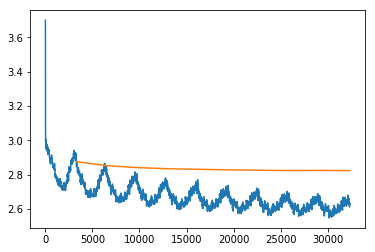

In [ ]:
if TRAIN:
    learn.recorder.plot_losses()

### Model Output

In [ ]:
if TRAIN:
    MODEL_OUTPUT_NAME = MODEL_PATH/'models'/f'{model_name}_best.pth'
    CLOUD_STORAGE = f'gs://w210-capstone/models/{model_name}_best.pth'

In [ ]:
!gsutil cp $MODEL_OUTPUT_NAME $CLOUD_STORAGE

Copying file://../data/models/4.1-LM-108k-lines-genre-song_title/models/4.1-LM-108k-lines-genre-song_title_best.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/150.5 MiB.                                    


In [60]:
ARCHITECTURE_PATH = MODEL_PATH/'models'/f'{model_name}_architecture.pkl'
ARCHITECTURE_STORAGE = f'gs://w210-capstone/models/{model_name}_architecture.pkl'
ITOS_PATH = MODEL_PATH/'tmp'/'itos.pkl'
ITOS_STORAGE = f'gs://w210-capstone/models/{model_name}_itos.pkl'

model_dump = learn.model
with open(ARCHITECTURE_PATH, 'wb') as f:
    pickle.dump(model_dump, f)

In [58]:
!gsutil cp $ARCHITECTURE_PATH $ARCHITECTURE_STORAGE

Copying file://../data/models/4.1-LM-108k-lines/models/4.1-LM-108k-lines_architecture.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/335.3 MiB.                                    


In [61]:
!gsutil cp $ITOS_PATH $ITOS_STORAGE

Copying file://../data/models/4.1-LM-108k-lines/tmp/itos.pkl [Content-Type=application/octet-stream]...
/ [1 files][310.1 KiB/310.1 KiB]                                                
Operation completed over 1 objects/310.1 KiB.                                    


## Text Generation

In [41]:
%load_ext autoreload
%autoreload 2

In [129]:
from src.nlp.generate_lyrics import DeepLyric

In [178]:
deep_lyric = DeepLyric(learn.model, weights=None, itos=data_lm.train_ds.vocab.itos)

In [181]:
deep_lyric.generate_text(seed_text='xbos xgenre', 
                         verbose=0, context_length=100, beam_width=4,
                         max_len=200, top_k=2, temperature=1.5,
                         GPU=True)

In [182]:
deep_lyric.print_lyrics()

xbos
 xgenre nan 
 xtitle burned from my girlfriend (lp version ) 

xbol-1 [verse-1] 
 i see them every morning 
 hoping she 'll be alright 
 her legs stick tight 
 that she don 't want to cry 
 
 (if you 're not looking for her ) 
 if she 's not looking for trouble 
 (i 'll tell you the truth ) 
 maybe this is not the right way to treat her right 
 (if you 're not looking for love ) 
 do you know what we 're looking for ? 
 
 [chorus] 
 if she 's looking to find the one 
 so i 'm asking what it 's for 
 like we used to do , i 've found some kind of love 
 a certain kind of way to find 
 some kind of loving for you 
 
 [outro] 
 what i 'm looking for 
 what i 'm looking for 
 what i 'm looking for 
 xeos
